In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
n_class = 10

X_train = np.reshape(X_train, (-1, 28 * 28)) / 255.
X_test = np.reshape(X_test, (-1, 28 * 28)) /255.

Y_train = np.eye(n_class)[Y_train]
Y_test = np.eye(n_class)[Y_test]

print("X_train.shape :", X_train.shape)
print("Y_train.shape :", Y_train.shape)
print()
print("X_test.shape :", X_test.shape)
print("Y_test.shape :", Y_test.shape)

X_train.shape : (60000, 784)
Y_train.shape : (60000, 10)

X_test.shape : (10000, 784)
Y_test.shape : (10000, 10)


In [0]:
class Model(object):
  def __init__(self, X_shape, Y_shape, n_hidden, n_layer, learning_rate):
    self.build_graph(X_shape, Y_shape, n_hidden, n_layer, learning_rate)
    
  def make_placeholder(self, X_shape, Y_shape):
    self.X = tf.placeholder(tf.float32, [None, X_shape[1]], name="X")
    self.Y = tf.placeholder(tf.int32, [None, Y_shape[1]], name="Y")
    
  def initialize_parameter(self, shape, name):
    var = tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer(seed=20181008))
    return var
  
  def fully_connected_layer(self, X, W, b, activation="softmax"):
    Z = tf.matmul(X, W) + b
    if activation is "softmax":
      A = tf.nn.softmax(Z)
    elif activation is "relu":
      A = tf.nn.relu(Z)
    return A
  
  def compute_cost(self, A, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=A, labels=Y))
    return cost
  
  def compute_acc(self, A, Y):
    self.Y_hat = tf.argmax(A, axis=1)
    self.Y_label = tf.argmax(Y, axis=1)
    equals = tf.equal(self.Y_label, self.Y_hat)
    acc = tf.reduce_mean(tf.cast(equals, tf.float32))
    return acc
  
  def build_graph(self, X_shape, Y_shape, n_hidden, n_layer, learning_rate):
    self.make_placeholder(X_shape, Y_shape)
    for n in range(1, n_layer+1):
      if n == 1:
        A = self.X
        n_input = X_shape[1]
      else:
        n_input = n_hidden
      
      if n == n_layer:
        n_output = Y_shape[1]
      else:
        n_output = n_hidden
        
      with tf.variable_scope("FC"+str(n), reuse=tf.AUTO_REUSE):
        W = self.initialize_parameter([n_input, n_output], "W"+str(n))
        b = self.initialize_parameter([n_output], "b"+str(n))
        if n==n_layer:
          A = self.fully_connected_layer(A, W, b, "softmax")
        else:
          A = self.fully_connected_layer(A, W, b, "relu")

    with tf.variable_scope("OP", reuse=tf.AUTO_REUSE):

      self.cost = self.compute_cost(A, self.Y)
      self.acc = self.compute_acc(A, self.Y)
      self.train = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)

In [0]:
epochs = 1001
learning_rate = 0.01
n_hidden = 128
n_layer = 3

myModel = Model(X_train.shape, Y_train.shape, n_hidden, n_layer, learning_rate)

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
for epoch in range(epochs):
  _, cost, acc = sess.run([myModel.train, myModel.cost, myModel.acc], feed_dict={myModel.X: X_train, myModel.Y: Y_train})
  if epoch % 100 == 0 :
    print("Epoch:", epoch,"\t", "Cost:",cost,"\t", "Acc:",acc * 100)
print("Train Acc:",acc*100)
acc = sess.run(myModel.acc, feed_dict={myModel.X: X_test, myModel.Y: Y_test})
print("Test Acc:", acc * 100 )

Epoch: 0 	 Cost: 2.3045838 	 Acc: 8.49333330988884
Epoch: 100 	 Cost: 1.5699034 	 Acc: 89.13166522979736
Epoch: 200 	 Cost: 1.4744058 	 Acc: 98.72166514396667
Epoch: 300 	 Cost: 1.4721823 	 Acc: 98.90166521072388
Epoch: 400 	 Cost: 1.4712304 	 Acc: 98.989999294281
Epoch: 500 	 Cost: 1.4707018 	 Acc: 99.04000163078308
Epoch: 600 	 Cost: 1.4704148 	 Acc: 99.06666874885559
Epoch: 700 	 Cost: 1.4700755 	 Acc: 99.09999966621399
Epoch: 800 	 Cost: 1.4699781 	 Acc: 99.1100013256073
Epoch: 900 	 Cost: 1.4698361 	 Acc: 99.12333488464355
Epoch: 1000 	 Cost: 1.4697565 	 Acc: 99.13166761398315
Train Acc: 99.13166761398315
Test Acc: 97.25000262260437


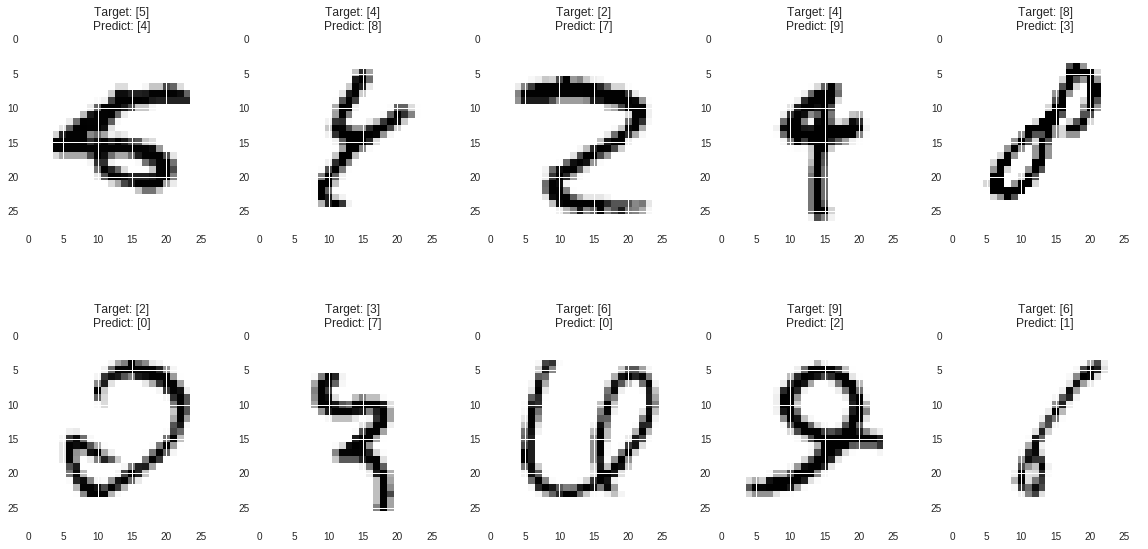

In [6]:
%matplotlib inline
Y_hat, Y_label = sess.run([myModel.Y_hat, myModel.Y_label], feed_dict={myModel.X: X_test, myModel.Y:Y_test})
fig=plt.figure(figsize=(20, 10))

not_equal= Y_hat!=Y_label
imgs = X_test[not_equal] 
r = np.random.randint(len(imgs)-10, size=1)
for i in range(10):
  img = imgs[i+r].reshape(28, 28)
  fig.add_subplot(2, 5, i+1)
  plt.imshow(img)
  plt.title("Target: "+str(Y_label[not_equal][i+r])+"\nPredict: "+ str(Y_hat[not_equal][i+r]) )
